# Naive Bayes Network notebook

#### Import dependencies

In [11]:
# Import dependencies
#%pip install pgmpy
#%pip install tabulate
#%pip install pandas
#%pip install networkx
#%pip install matplotlib

#### Load libraries

In [12]:
# Load libraries
import pgmpy as pg
import tabulate as tb
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Data import and cleaning

#### Import BigPerf data

In [13]:
# Import data
df = pd.read_csv("C:\\Users\\Keir McGlinn-Shaw\\Documents\\Stage-3\\Dissertation\\Data\\Use\\BigPerfMetrics.csv")

df.head()

,Block_ID,HDFS_BW,HDFSTranmissionTime,Mapper_ID,Mapper_VM_MIPS,MapExecutionTime,MapperBW,MapperTransmissionTime,Reducer_ID,Reducer_VM_MIPS,ReducerExecutionTime,ReducerBW,ReducerTransmissionTime,Block_ID.1,Block_BW,BlockTransmissionTime,TransactionTime
0,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,30.00,2.53,reducer0,341739,480,3.80,250.14,reducer0_Block_1,0.0,0.00,1578.79
1,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,30.00,2.53,reducer1,150000,120,50.00,18.99,reducer1_Block_1,50.0,20.00,1007.64
2,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,16.76,3.25,reducer2,382530,480,4.48,212.22,reducer2_Block_1,3.7,270.02,1811.61
3,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,16.76,3.25,reducer3,150000,120,5.88,161.57,reducer3_Block_1,3.7,270.02,1400.96
4,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,18.41,4.16,reducer4,457419,480,5.88,161.53,reducer4_Block_1,3.7,270.02,1761.83


#### Clean data of unwanted variables and missing values

In [14]:
# Clean data
df.dropna()

df.drop(labels=['Block_ID', 'Mapper_ID', 'Reducer_ID', 'Block_ID.1'], axis=1, inplace=True)

df.head()

,HDFS_BW,HDFSTranmissionTime,Mapper_VM_MIPS,MapExecutionTime,MapperBW,MapperTransmissionTime,Reducer_VM_MIPS,ReducerExecutionTime,ReducerBW,ReducerTransmissionTime,Block_BW,BlockTransmissionTime,TransactionTime
0,11.81,80.63,652289,765.49,30.00,2.53,341739,480,3.80,250.14,0.0,0.00,1578.79
1,11.81,80.63,652289,765.49,30.00,2.53,150000,120,50.00,18.99,50.0,20.00,1007.64
2,11.81,80.63,652289,765.49,16.76,3.25,382530,480,4.48,212.22,3.7,270.02,1811.61
3,11.81,80.63,652289,765.49,16.76,3.25,150000,120,5.88,161.57,3.7,270.02,1400.96
4,11.81,80.63,652289,765.49,18.41,4.16,457419,480,5.88,161.53,3.7,270.02,1761.83


#### Rename columns to better fit in drawn charts and for ease of use

In [15]:
# Rename column headers to abbreviations

nodes = ['HBW', 'HTT', 'MMIPS', 'MET', 'MBW', 'MTT', 'RMIPS', 'RET', 'RBW', 'RTT', 'BBW', 'BTT', 'TT']

df.columns = nodes

df.head(10)

,HBW,HTT,MMIPS,MET,MBW,MTT,RMIPS,RET,RBW,RTT,BBW,BTT,TT
0,11.81,80.63,652289,765.49,30.00,2.53,341739,480,3.80,250.14,0.0,0.00,1578.79
1,11.81,80.63,652289,765.49,30.00,2.53,150000,120,50.00,18.99,50.0,20.00,1007.64
2,11.81,80.63,652289,765.49,16.76,3.25,382530,480,4.48,212.22,3.7,270.02,1811.61
3,11.81,80.63,652289,765.49,16.76,3.25,150000,120,5.88,161.57,3.7,270.02,1400.96
4,11.81,80.63,652289,765.49,18.41,4.16,457419,480,5.88,161.53,3.7,270.02,1761.83
5,11.81,80.63,652289,765.49,18.41,4.16,150000,120,6.98,136.24,3.7,270.02,1376.54
6,11.81,80.63,652289,765.49,18.41,4.16,563904,480,3.80,250.14,3.7,270.02,1850.44
7,11.81,80.63,652289,765.49,18.41,4.16,150000,120,150.00,6.33,3.7,270.02,1246.63
8,11.81,80.63,652289,765.49,18.41,4.16,430890,480,3.80,250.14,3.7,270.02,1850.44
9,11.81,80.63,652289,765.49,18.41,4.16,150000,120,150.00,6.33,3.7,270.02,1246.63


#### Define funtion to discretise data into three catagories

In [16]:
'''
Splits data into three bins of equal size using: https://pandas.pydata.org/docs/reference/api/pandas.cut.html
'''
def split_tertiles(df):
    tertile_labels = ['0.Low', '1.Medium', '2.High']

    tert_df = pd.DataFrame()

    for column_name in df:
        tert_df[column_name] = pd.cut(df[column_name], 3, labels=tertile_labels, ordered=True)

    # Change type of values stored in dataframe to avoid errors arrising from using the Category type when the dataframe is fed into the pgmpy.metrics.metrics correlation_score function
    tert_df = tert_df.astype('object')

    return tert_df

#### Descritise data into catagories

In [17]:
# Discretise BigPerf dataset
cat_df = split_tertiles(df)

cat_df.head()

,HBW,HTT,MMIPS,MET,MBW,MTT,RMIPS,RET,RBW,RTT,BBW,BTT,TT
0,2.High,0.Low,0.Low,0.Low,2.High,0.Low,1.Medium,2.High,0.Low,2.High,0.Low,0.Low,0.Low
1,2.High,0.Low,0.Low,0.Low,2.High,0.Low,0.Low,0.Low,0.Low,0.Low,2.High,0.Low,0.Low
2,2.High,0.Low,0.Low,0.Low,1.Medium,0.Low,1.Medium,2.High,0.Low,2.High,0.Low,2.High,1.Medium
3,2.High,0.Low,0.Low,0.Low,1.Medium,0.Low,0.Low,0.Low,0.Low,1.Medium,0.Low,2.High,0.Low
4,2.High,0.Low,0.Low,0.Low,1.Medium,0.Low,2.High,2.High,0.Low,1.Medium,0.Low,2.High,1.Medium


In [18]:
from itertools import combinations

import networkx as nx
from sklearn.metrics import f1_score
from pgmpy.models import BayesianModel, NaiveBayes
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch
from pgmpy.estimators import K2Score, BicScore, BDeuScore
from pgmpy.utils import get_example_model
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator

In [19]:
model = NaiveBayes(feature_vars=['HBW', 'HTT', 'MMIPS', 'MET', 'MBW', 'MTT', 'RMIPS', 'RET', 'RBW', 'RTT', 'BBW', 'BTT'], dependent_var='TT')

In [20]:
model.fit(data=cat_df, parent_node='TT', estimator=MaximumLikelihoodEstimator )
bayes_model = BayesianModel(model.edges)

bayes_model.fit(data=cat_df,
    estimator=MaximumLikelihoodEstimator,
    complete_samples_only=False)

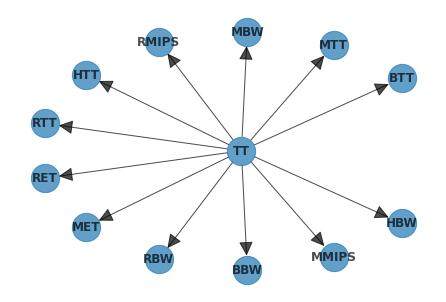

In [21]:
G = nx.DiGraph()
G.add_edges_from(bayes_model.edges)
G.add_nodes_from(bayes_model.nodes)
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos=pos, with_labels=True, arrowsize=30, node_size=800, alpha=0.7, font_weight="bold")  # Draw the original graph

In [22]:
bayes_model.get_cpds()

[<TabularCPD representing P(BBW:2 | TT:3) at 0x1d1a8b8df40>,
 <TabularCPD representing P(BTT:2 | TT:3) at 0x1d1a8babf10>,
 <TabularCPD representing P(HBW:2 | TT:3) at 0x1d1a8babee0>,
 <TabularCPD representing P(HTT:2 | TT:3) at 0x1d1a8babf40>,
 <TabularCPD representing P(MBW:3 | TT:3) at 0x1d1a8bb6ca0>,
 <TabularCPD representing P(MET:3 | TT:3) at 0x1d1a8bb68b0>,
 <TabularCPD representing P(MMIPS:3 | TT:3) at 0x1d1a8bb6460>,
 <TabularCPD representing P(MTT:3 | TT:3) at 0x1d1a8bb6940>,
 <TabularCPD representing P(RBW:2 | TT:3) at 0x1d1a8bb6700>,
 <TabularCPD representing P(RET:2 | TT:3) at 0x1d1a8bb61f0>,
 <TabularCPD representing P(RMIPS:3 | TT:3) at 0x1d1a8bb6df0>,
 <TabularCPD representing P(RTT:3 | TT:3) at 0x1d1a8bc1ca0>,
 <TabularCPD representing P(TT:3) at 0x1d1a8bc1430>]

In [23]:
print(f'Check model: {bayes_model.check_model()}\n')
for cpd in bayes_model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

Check model: True

CPT of BBW:
+-------------+---------------------+----------------------+------------+
| TT          | TT(0.Low)           | TT(1.Medium)         | TT(2.High) |
+-------------+---------------------+----------------------+------------+
| BBW(0.Low)  | 0.6078886310904872  | 0.9387608069164265   | 1.0        |
+-------------+---------------------+----------------------+------------+
| BBW(2.High) | 0.39211136890951276 | 0.061239193083573486 | 0.0        |
+-------------+---------------------+----------------------+------------+ 

CPT of BTT:
+-------------+--------------------+--------------------+---------------------+
| TT          | TT(0.Low)          | TT(1.Medium)       | TT(2.High)          |
+-------------+--------------------+--------------------+---------------------+
| BTT(0.Low)  | 0.4222737819025522 | 0.1873198847262248 | 0.09153952843273232 |
+-------------+--------------------+--------------------+---------------------+
| BTT(2.High) | 0.5777262180974478 | 